In [1]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cbpro

import os
import shutil
import urllib
import zipfile
from pathlib import Path
import seaborn as sns

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)

public_client = cbpro.PublicClient()


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [10]:
class MinerMeta(type):
    def compile_historic(self, timestamp=False, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv == True:
            df = pd.read_csv(file, index_col="time")
            return df
        else:
            start_date = datetime(2020, 1, 1)
            end_date = datetime.today()
            delta = timedelta(hours=300)
            df = pd.DataFrame()

        while start_date <= end_date:
            historic = public_client.get_product_historic_rates(
                f"{self.coin}-USD",
                granularity=3600,
                start=start_date,
                end=start_date + delta,
            )
            start_date += delta
            df = df.append(historic, ignore_index=True)
        df.columns = ["time", "low", "high", "open", "close", "volume"]
        date_time = pd.to_datetime(df["time"], unit="s")

        timestamp_s = date_time.map(pd.Timestamp.timestamp)
        day = 24 * 60 * 60
        year = (365.2425) * day
        df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
        df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
        df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
        df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
        df.reset_index(drop=True, inplace=True)

        if timestamp is True:
            pass
        else:
            df["time"] = pd.to_datetime(df["time"], unit="s")

        if write_csv is True:
            df.to_csv(file, index=False)

        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()

        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        years_per_dataset = n_samples_h / (hours_per_year)

        f_per_year = f_per_dataset / years_per_dataset
        plt.step(f_per_year, np.abs(fft))
        plt.xscale("log")
        plt.ylim(1000, 50000)
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # Train Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_mean = train_df.mean()
        train_std = train_df.std()

        train_df = (train_df - train_mean) / train_std
        val_df = (val_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std
        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_mean) / train_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("Training Data Feature Dist with whole DF Mean")
            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        setattr(cls, "compile_historic", self.compile_historic)
        setattr(cls, "year_day_fft", self.year_day_fft)
        setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "make_dataset", self.compile_historic)

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class eth(metaclass=MinerMeta):
    coin = "eth"


,low,high,open,close,volume,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,
2020-01-13 12:00:00,-0.759311,-0.760038,-0.760131,-0.759461,-0.677813,-0.001305,-1.413479,0.176817,1.198609
2020-01-13 11:00:00,-0.759181,-0.758655,-0.757875,-0.760020,-0.693022,0.364764,-1.365301,0.175797,1.198822
2020-01-13 10:00:00,-0.758942,-0.758336,-0.759228,-0.757937,-0.572875,0.705887,-1.224051,0.174777,1.199034
2020-01-13 09:00:00,-0.759029,-0.759442,-0.758476,-0.759225,-0.746656,0.998815,-0.999354,0.173756,1.199246
2020-01-13 08:00:00,-0.759572,-0.759548,-0.760002,-0.758968,-0.717893,1.223587,-0.706523,0.172735,1.199456


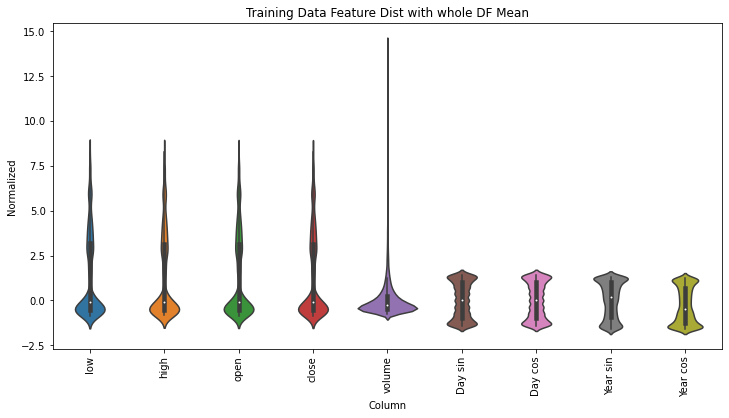

In [12]:
df = eth.compile_historic(read_csv=True)

train, val, test = eth.ttsplit_norm(df, feature_plot=True)

train.head()